<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_11_Data_Storytelling_with_Zombies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telling a Story (About Zombies) with Your Data
### Brendan Shea, PhD

In this chapter, we delve into the heart of data analysis: the art and science of interpreting your data and communicating your findings effectively. Your journey through this course has equipped you with the fundamental skills to gather, organize, and manipulate data. Now, we turn our attention towards the real-world challenge of extracting meaningful insights from our datasets and presenting these insights in a manner that allows others to understand and act upon them.

We will begin by exploring how to clean and structure data to facilitate downstream analysis. This often overlooked step is crucial in ensuring the integrity of your analyses and, consequently, the reliability of your findings.

Next, we turn to the essential task of visualizing data. We'll delve into various techniques for presenting different types of data, including geographical and temporal data. We will also discuss the development of interactive dashboards, a powerful tool for real-time data monitoring and decision-making.

We will then transition into the realm of descriptive and inferential statistics. Descriptive statistics help us summarize and understand the characteristics of our dataset. Inferential statistics, on the other hand, enable us to make predictions and inferences about a population based on a sample.

Finally, we will address the all-important task of report writing. Here we will discuss how to structure a report, how to communicate complex information clearly and succinctly, and how to ensure your report is both engaging and informative.

Throughout this chapter, we will be mindful of potential biases and confounding factors that could impact our analyses. We will also discuss the importance of data privacy and ethics, particularly when handling sensitive information.



**Brendan's Note:** This chapter will demonstrate some more "advanced" topic in data analysis. The goal here is not to memorize each and every function, but rather to get a sense of "how these things work" at a high level. (So, don't worry if you don't "get" everything right away--no one does!).

## Case Study: Zombies!

Now, let's bring these concepts to life with a case study. You are a junior analyst at the Centers for Disease Control and Prevention (CDC). Suddenly, an outbreak of a mysterious illness begins to spread rapidly across the country. The symptoms appear zombie-like, and public fear is rising. Your task is to analyze the data coming in from across the nation, make sense of it, and communicate your findings to various stakeholders. This high-stakes scenario will give you a taste of what data analysts face in real-world crises.

As we proceed through this chapter, we will apply the concepts we learn to this unfolding crisis, helping the CDC understand and combat the spread of this terrifying outbreak. Let's get started!

## Extract, Transform, Load (ETL)

Extract, Transform, Load (ETL) is a critical process used in data handling, particularly in data warehousing. It's a three-step procedure:

1.  **Extract:** Data is extracted from various sources, which could be databases, Excel files, web pages, or even text files. The nature of these sources often means the data is in different formats and structures.

2.  **Transform:** This is the process of converting the extracted data into a form that can be analyzed more effectively. Transformations may include cleaning (removing errors or inconsistencies), filtering, splitting or merging fields, converting data types, or creating new calculated fields.

3.  **Load** The final step is to load the transformed data into a final target database or data warehouse, where it can be accessed and analyzed. This data store is often designed differently from operational databases, optimized for analysis rather than transactional processing.

As a junior analyst at the CDC tasked with responding to a Zombie outbreak, you'll be dealing with data from many sources. You might have case reports coming in from hospitals in various formats, laboratory test results coming from different lab systems, demographic data from census databases, and even social media posts or news reports. Each of these data sources will have its own structure and quirks.

The ETL process allows you to consolidate all this diverse data into a consistent format in a single location. This makes it much easier to analyze the data, spot trends and patterns, and generate reports. For example, you might need to generate a daily report of new Zombie cases, or analyze case data to identify risk factors for severe symptoms. ETL is the process that enables these activities, ensuring that the data you're working with is accurate, consistent, and up-to-date.

### Extract

Just as Zombies aim to "extract" brains from heads, the first step in the ETL process is to **extract** the data from its source. In this case, our data is stored in a CSV file. We'll use the Python library `pandas` to read this CSV file and load the data into a **pandas** DataFrame.

Let's start by loading our data.

In [1]:
import pandas as pd

# download our data
!wget https://github.com/brendanpshea/database_sql/raw/main/data/zombie_outbreak.csv -q -N
# Load the data from the CSV file
df = pd.read_csv('zombie_outbreak.csv')
# Display the first few rows of the dataframe
df.head(10)

,case_id,report_date,location,symptom_severity,case_status,age
0,0,2028-02-01,MN,Just a Scratch,Recovered,80
1,1,2028-02-02,MN,Just a Scratch,Lost to the Horde,37
2,2,2028-02-03,MN,Just a Scratch,Turned,34
3,3,2028-02-04,MN,Just a Scratch,Unknown,48
4,4,2028-02-05,MN,Just a Scratch,Recovered,79
5,5,2028-02-06,MN,Bitten,Recovered,50
6,6,2028-02-07,MN,Mauled,Unknown,-1
7,7,2028-02-08,MN,Just a Scratch,Recovered,22
8,8,2028-02-09,MN,Just a Scratch,Turned,55
9,9,2028-02-10,MN,Just a Scratch,Recovered,46


Our data consists of several fields:

1.  `case_id`: A unique identifier for each case.
2.  `report_date`: The date when the case was reported.
3.  `location`: The location where the case was reported.
4.  `symptom_severity`: The severity of the symptoms.
5.  `case_status`: The status of the case (e.g., Infected, Recovered).
6.  `age`: The age of the individual.
    - It looks like -1 is used to code "age not known."

Now, let's see what sorts of values we have in the (non-numeric) colums:

In [2]:
print(df.location.unique(), "\n",
df.symptom_severity.unique(), "\n",
df.case_status.unique(), "\n",
)

['MN' 'WI' 'IA' 'SD' 'ND' 'NE' 'IL' 'MI' 'IN'] 
 ['Just a Scratch' 'Bitten' 'Mauled'] 
 ['Recovered' 'Lost to the Horde' 'Turned' 'Unknown'] 



This code block is using the `print` function in Python, which simply displays the output of the code inside its parentheses. It is printing three different outputs here, separated by newline characters (`"\n"`), which create a break or new line in the output.

Let's break this down further:

1.  `df.location.unique()`: This statement is using the `unique` method of the pandas DataFrame (df). This method is used to find the unique elements of a particular column ('location') in the DataFrame. In other words, it is showing all the distinct values that exist in the 'location' column of the data. This is useful when you want to understand the diversity of your dataset - for instance, to see how many different locations are represented in your data. Here, the data is focused on midwest statees.

2.  `df.symptom_severity.unique()`: Similar to the above, this statement is finding all the unique elements in the 'symptom_severity' column of the DataFrame. This could be useful for understanding what different severity levels exist in your dataset.

3.  `df.case_status.unique()`: Again, this statement is finding all unique elements in the 'case_status' column of the DataFrame.

In the context of data cleaning and ETL (Extract, Transform, Load) process, this kind of code is often used in the exploratory phase. Before you can clean or transform your data, you need to understand what's in it. This code helps by showing what unique values exist in these particular columns, and could assist in identifying any inconsistencies, typos or outliers in the data. For example, we see that some values of `case_status` are "unknown."

### Transform

Just as an unlucky bite from a Zombie can change a person into a Zombie, transformation involves cleaning and preparing the data for the database. The exact transformations will depend on the specific data and the needs of the database.

One of the most common issues when working with data is dealing with missing or unknown values. These can be represented in many ways, including special symbols, placeholder text, or specific numbers. In our Zombie outbreak dataset, "unknown" values in the `case_status` column and -1 values in the `age` column represent missing or unknown data.

Why might we want to replace these placeholders with NULLs?

1.  Accuracy: The placeholder values might be mistaken for actual data. For example, -1 is a valid number, so if someone didn't know it was being used as a placeholder, they might include it in numerical calculations, which would give inaccurate results.

2.  Compatibility: Some systems and databases have built-in support for handling NULLs. For example, SQL has several functions that specifically deal with NULL values.

3.  Standardization: NULL is a widely recognized representation for missing or unknown data. Using NULL instead of various different placeholders helps make your data more consistent and understandable.

Let's replace these placeholder values with NULLs in our data. We'll also convert the `report_date` column to a datetime data type, which is more appropriate for date data.

In [3]:
# Replace "unknown" and -1 with NULL
df['case_status'] = df['case_status'].replace('unknown', None)
df['age'] = df['age'].replace(-1, None)

# Convert report_date to datetime
df['report_date'] = pd.to_datetime(df['report_date'])

# Check the data types and the first few rows of the dataframe
df.dtypes, df.head(10)


(case_id                      int64
 report_date         datetime64[ns]
 location                    object
 symptom_severity            object
 case_status                 object
 age                         object
 dtype: object,
    case_id report_date location symptom_severity        case_status   age
 0        0  2028-02-01       MN   Just a Scratch          Recovered    80
 1        1  2028-02-02       MN   Just a Scratch  Lost to the Horde    37
 2        2  2028-02-03       MN   Just a Scratch             Turned    34
 3        3  2028-02-04       MN   Just a Scratch            Unknown    48
 4        4  2028-02-05       MN   Just a Scratch          Recovered    79
 5        5  2028-02-06       MN           Bitten          Recovered    50
 6        6  2028-02-07       MN           Mauled            Unknown  None
 7        7  2028-02-08       MN   Just a Scratch          Recovered    22
 8        8  2028-02-09       MN   Just a Scratch             Turned    55
 9        9  2028-

We have successfully replaced the placeholders with NULLs and converted the `report_date` column to datetime format. Our data is now clean and ready to be loaded into a database.

It's important to note that the transformations needed will depend on the specific data you're working with. For example, you might need to handle different types of missing value indicators, convert other data types, or perform more complex cleaning tasks.

## Load
The final step in the ETL process is loading the transformed data into the destination system. In our case, we're loading the data into a SQLite database, which is a lightweight disk-based database that doesn't require a separate server process. In Zombie terms, we might think of this as an infected person ready to assume their final (Zombie) form, ready to go off and eat some brains.

We'll use the `sqlite3` library in Python to load our data into a SQLite database. Let's create a new SQLite database and load our data into a table in this database. We'll name the table "zombie_outbreak".

Note that if the specified database does not exist, `sqlite3` will automatically create it. If the table already exists, it will be replaced with our new data. Let's proceed with loading the data.

In [4]:
import sqlite3

# Create a connection to the SQLite database
# If the database does not exist, it will be created
conn = sqlite3.connect('zombie_outbreak.db')

# Write the data to a SQLite table
df.to_sql('zombie_outbreak', conn, if_exists='replace', index=False)

# Close the connection to the database
conn.close()

The data has now been loaded into a SQLite database in a table named "zombie_outbreak".

To verify that the data has been loaded correctly, we can fetch and display the first few rows from the "zombie_outbreak" table in the SQLite database. Let's do that now.

In [5]:
# First, we create a database and connect to it
!pip install SQLAlchemy==1.3.24 -q # Needed o avoid problems with more recent version in Colab

%load_ext sql
%sql sqlite:///zombie_outbreak.db

%sql SELECT * FROM zombie_outbreak LIMIT 10;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
 * sqlite:///zombie_outbreak.db
Done.


case_id,report_date,location,symptom_severity,case_status,age
0,2028-02-01 00:00:00,MN,Just a Scratch,Recovered,80
1,2028-02-02 00:00:00,MN,Just a Scratch,Lost to the Horde,37
2,2028-02-03 00:00:00,MN,Just a Scratch,Turned,34
3,2028-02-04 00:00:00,MN,Just a Scratch,Unknown,48
4,2028-02-05 00:00:00,MN,Just a Scratch,Recovered,79
5,2028-02-06 00:00:00,MN,Bitten,Recovered,50
6,2028-02-07 00:00:00,MN,Mauled,Unknown,None
7,2028-02-08 00:00:00,MN,Just a Scratch,Recovered,22
8,2028-02-09 00:00:00,MN,Just a Scratch,Turned,55
9,2028-02-10 00:00:00,MN,Just a Scratch,Recovered,46


As we can see, the data has been successfully loaded into the SQLite database. The queried rows from the SQLite database match the first few rows of our original data.

To summarize, we've successfully conducted an ETL process:

1.  Extracted data from a CSV file using `pandas`.
2.  Transformed the data by replacing placeholder values with NULLs, converting data types, and checking for any missing values.
3.  Loaded the data into a SQLite database using `sqlite3`.

This data is now ready for analysis. As a CDC analyst, you can now query this database to find patterns, generate reports, or input this data into a machine learning model to make predictions.

Remember, the ETL process is a crucial step in ensuring that your data is accurate, consistent, and ready for analysis. By following this guide, you should be able to apply these ETL concepts to your own data tasks.

## A Bit More on Pandas

Pandas is a powerful data manipulation library in Python. It provides flexible and efficient data structures that make data manipulation and analysis easy.

Pandas is built on top of two core Python libraries - Matplotlib for data visualization and NumPy for mathematical operations. Pandas allows you to do complex data manipulation with simple, one-line commands.

One of the key data structures in Pandas is the DataFrame, which is a two-dimensional labeled data structure with columns that can be of different types (like integers, strings, and datetimes).

Let's take a deeper look at some of the Pandas functionalities we've used in our ETL process:

### `pd.read_csv()`

This is a function in pandas that reads CSV files and converts them into DataFrame. It has various options allowing you to, for example, specify the delimiter, handle missing values, skip rows, etc.

In our ETL process, we used this function to load our Zombie outbreak data from a CSV file:


```
df = pd.read_csv('zombie_outbreak.csv')
```

### `df.head()`

This is a function that returns the first n rows of the DataFrame. This is useful to get a glimpse of the data after loading it. By default, it returns the first 5 rows.

We used this function several times to display the first 10 rows of our data:

```
df.head(10)
```

### `df.replace()`

This function replaces a set of values with another set of values in the DataFrame. We used this function to replace the "unknown" values and -1 values with NULLs in our data:

```
df['case_status'] = df['case_status'].replace('unknown', None)
df['age'] = df['age'].replace(-1, None)
```

### `pd.to_datetime()`

This function converts a series of string representations of dates and times to a series of datetime objects. We used this function to convert the `report_date` column to datetime:

```
df['report_date'] = pd.to_datetime(df['report_date'])
```

### `df.dtypes`

This is an attribute (not a function) that returns the data types of each column in the DataFrame. This is useful to check if the data types are what we expect. For example, we want `report_date` to be a datetime, `location` to be a string, `case_status` to be a categorical variable, and `age` to be an integer.

```
df.dtypes
```

### `df.to_sql()`

This function writes records stored in a DataFrame to a SQL database. We used this function to load our data into a SQLite database:

```
df.to_sql('zombie_outbreak', conn, if_exists='replace', index=False)
```

Here, `conn` is a connection object to our SQLite database, `'zombie_outbreak'` is the name of the table we want to create in the database, `if_exists='replace'` means that if the table already exists, it will be replaced with our new data, and `index=False` means that the index of the DataFrame will not be included as a column in the table.

## Data Reporting
Data reporting is the crucial process of collecting and submitting data which gives insightful information on various key performance indicators (KPIs). In the realm of data analysis, reports are the culmination of all the hard work done in cleaning, transforming, and analyzing data. They are the tangible products that help guide decision-making processes in organizations.

For you, a junior analyst at the CDC embarking on the thrilling journey of fighting a Zombie outbreak, reporting is the critical task that stands between survival and apocalypse.

Imagine the scene. The Zombie outbreak is spreading rapidly. In a CDC command center, rows of analysts, illuminated only by the glow of their monitors, are hunched over keyboards, sifting through countless rows of data. These analysts, the unsung heroes of this epic battle against the undead, are turning raw, chaotic data into coherent narratives that will guide the CDC's response.

You're one of these analysts. As a junior data analyst, you may not be out there in the field fighting Zombies, but your role is no less important. Your reports could provide the key insights that guide the development of the anti-Zombie vaccine or inform the strategies to contain the outbreak. Your work could be the difference between a city saved or a city lost to the Zombie hordes.

As you sit at your desk, sipping your fifth coffee of the night, you pull up the latest data on your screen. It's messy, disparate, and initially intimidating. But you know that hidden in this data is the information the CDC needs to turn the tide of the battle. With determination in your heart and a steady hand on your mouse, you dive into the data, ready to craft a report that will provide clarity in the midst of chaos.

In the war against the Zombie outbreak, data is your weapon, analysis is your strategy, and reporting is your battle cry. It's time to roll up your sleeves, dive into the data, and help save the world!

## Know Your Audience

"Know your audience" is a cornerstone principle not just in writing and communication, but especially in data reporting. Different audiences (or **stakeholders**) have different needs, different levels of expertise, and different ways of interpreting information. Knowing who you're reporting to can significantly impact the design, content, and delivery of your report.

Let's consider a few different audiences in our Zombie outbreak scenario:

1.  **CDC Leadership:** This audience needs high-level summaries and trends. They're interested in strategic insights that help them guide the overall response to the outbreak. They might not have the time (or the interest) to delve into the nitty-gritty details of your data. They want to know: How many new cases are we seeing? Is the outbreak spreading or contained? Are certain treatments more effective than others? Give them charts that clearly show trends over time, maps to illustrate the geographical spread, and summary tables of key data points. And please, keep the technical jargon to a minimum. They might not remember what an "interquartile range" is, and you don't want them to have to fight off Zombies with a statistics textbook.

2.  **Field Agents:** These are the brave souls out in the field, dealing directly with the Zombie outbreak. They need specific, actionable information. They want to know: Where are the new cases? What symptoms should we be looking out for? How effective are our current containment strategies? This audience will appreciate detailed maps, lists of symptoms to look out for, and clear instructions based on your data analysis. Keep in mind, they're probably reading your reports on a mobile device, in between dodging Zombie hordes. So, make sure your reports are concise, clear, and can be easily read on a small screen.

3.  **Lab Scientists:** These are the experts working tirelessly to develop the Zombie vaccine. They need detailed, technical data to guide their research. They're interested in things like: What are the characteristics of the infected cases? Are there any commonalities? Are certain treatments showing promise? This audience will appreciate detailed tables of data, complex charts showing correlations and trends, and technical explanations of your analysis. They're not afraid of jargon or complexity, but make sure your analysis is rigorous and your methods are clearly explained. They're trying to save humanity with science, after all.

4.  **General Public:** This is perhaps the most diverse audience. They're scared, they're looking for information, and they're depending on you to provide accurate, understandable updates. They want to know: How many cases are there? Where is it safe? How can we protect ourselves? This audience needs clear, simple visualizations, like maps and bar charts, and non-technical language. Be careful not to cause unnecessary panic - remember, they're already dealing with Zombies, they don't need the added stress of confusing data.

Remember, each of these audiences has different needs, different levels of expertise, and different ways of interpreting information. Tailoring your reports to your audience will ensure that your data is not just heard, but understood and acted upon. In the fight against Zombies, clear communication is just as important as a good baseball bat.

## Fetching Data with SQL
To obtain the data needed for our reports, you'll need to perform SQL queries on your SQLite database. Let's start by fetching the total number of cases over time. We'll group by the report date and count the number of cases on each date:

In [6]:
%%sql
--Get cases by month
SELECT strftime('%Y-%m', report_date) as report_month, COUNT(*) as total_cases
FROM zombie_outbreak
GROUP BY report_month
ORDER BY report_month;


 * sqlite:///zombie_outbreak.db
Done.


report_month,total_cases
2028-02,40
2028-03,87
2028-04,170
2028-05,359
2028-06,702
2028-07,1465
2028-08,2177


In this query, `SELECT strftime('%Y-%m', report_date) as report_month, COUNT(*) as total_cases`,  tells SQLite to return the following columns:

- `report_month:` The month of the report date, formatted as YYYY-MM.
- `total_cases:` The total number of cases in the month.

The `strftime()` function is used to format the report_date column as `YYYY-MM`. The `COUNT(*)` function is used to count the number of rows in the zombie_outbreak table.


### Query: Locations

To fetch the distribution of cases by location, we can modify the above query to group by location instead of report date:

In [7]:
%%sql
SELECT location, COUNT(*) as total_cases
FROM zombie_outbreak
GROUP BY location
ORDER BY total_cases DESC;


 * sqlite:///zombie_outbreak.db
Done.


location,total_cases
MN,787
WI,746
IA,680
SD,665
ND,592
NE,547
IL,448
MI,356
IN,179


This query will give us the total number of cases in each location, ordered from highest to lowest.

### Query: Symptom Severity
To fetch the distribution of symptom severity, we can group by the `symptom_severity` column:

In [8]:
%%sql
SELECT symptom_severity, COUNT(*) as total_cases
FROM zombie_outbreak
GROUP BY symptom_severity
ORDER BY total_cases;


 * sqlite:///zombie_outbreak.db
Done.


symptom_severity,total_cases
Mauled,753
Bitten,1050
Just a Scratch,3197


### Query: Age Distribution
Finally, to figure out the age distribution (grouped by decade), we can do the following:

In [9]:
%%sql
SELECT (age / 10) * 10 as age_decade, COUNT(*) as total_cases
FROM zombie_outbreak
WHERE age IS NOT NULL
GROUP BY age_decade
ORDER BY age_decade;


 * sqlite:///zombie_outbreak.db
Done.


age_decade,total_cases
0,103
10,181
20,415
30,697
40,857
50,882
60,700
70,398
80,192
90,73


In this query, we use integer division `(age/10)` to turn numbers like 35, 23, or 68 into 3, 2, and 6. Then, we multiply by 10 to get back the "decade."

## Basic Statistics with SQL and Pandas

SQL provides several functions that can be used to calculate basic statistics:

-   `COUNT:` Returns the number of rows that match a specified criterion.
-   `SUM:` Returns the total sum of a numeric column.
-   `AVG:` Returns the average of a set of values.
-   `MIN:` Returns the smallest value of the selected column.
-   `MAX:` Returns the largest value of the selected column.

For example, if we want to find out thethe youngest, oldest, and average age in our Zombie outbreak dataset, we could use the following SQL queries:

In [10]:
%%sql
SELECT ROUND(AVG(age), 2) AS "Average Age",
  MIN(age) AS "Youngest",
  MAX(age) AS "Oldest"

FROM zombie_outbreak
WHERE age IS NOT NULL

 * sqlite:///zombie_outbreak.db
Done.


Average Age,Youngest,Oldest
49.64,0,123


Pandas (which we touched on eariler) provides us with some more advanced data processing abilities. To read the result of SQL query into a Pandas dataframe we can use the following sytax:

```
%sql df_result <<  SQL query
df_result = df_result.DataFrame()
```
Once we do this, we can take advantage of the (many) statistical tools that Pandas makes available to us. For example, we can use the `describe(include='all')` method to get an overview of our data.

In [16]:
# Let's get all data prior to August 15, 2028
%sql df_zombies <<  SELECT * FROM zombie_outbreak;
df_zombies = df_zombies.DataFrame()

 * sqlite:///zombie_outbreak.db
Done.
Returning data to local variable df_zombies


In [17]:
df_zombies.describe(include = 'all')

,case_id,report_date,location,symptom_severity,case_status,age
count,5000.000000,5000,5000,5000,5000,4534.000000
unique,NaN,207,9,3,4,NaN
top,NaN,2028-08-24 00:00:00,MN,Just a Scratch,Recovered,NaN
freq,NaN,114,787,3197,2506,NaN
mean,2499.500000,NaN,NaN,NaN,NaN,49.643361
std,1443.520003,NaN,NaN,NaN,NaN,19.752351
min,0.000000,NaN,NaN,NaN,NaN,0.000000
25%,1249.750000,NaN,NaN,NaN,NaN,36.000000
50%,2499.500000,NaN,NaN,NaN,NaN,50.000000
75%,3749.250000,NaN,NaN,NaN,NaN,63.000000


The `.describe()` method in pandas is a way to get a quick overview of your data. It provides various summary statistics, including count, mean, standard deviation, minimum, and maximum. Here's what each of these mean (NOTE: The specific numbers you see may vary):

-   **count:** This is the number of non-missing values for each column. For 'case_id', it's 5000, which means there are 5000 case IDs in the dataset. For 'age', it's 4534, meaning there are 4534 non-missing age values in the dataset. The difference (5000 - 4534 = 466) is the number of missing age values.

-   **unique:** This is the number of distinct values in a column. This only applies to categorical or string data, not numerical data (which is why it's NaN for 'case_id' and 'age'). For 'location', 'symptom_severity', and 'case_status', the number of unique categories are shown.

-   **top:** This is the most common value in a column. Like 'unique', this only applies to categorical or string data. For example, 'MN' is the most common location, 'Just a Scratch' is the most common symptom severity, and 'Recovered' is the most common case status.

-   **freq:** This is the frequency of the most common value. For example, 'MN' appears as the location 787 times, 'Just a Scratch' appears as the symptom severity 3197 times, and 'Recovered' appears as the case status 2506 times.

-   **mean:** This is the average value. For 'case_id', the mean is 2499.5, and for 'age', it's 49.64.

-   **std:** This is the standard deviation, which measures the dispersion of values. A high standard deviation means the values are spread out; a low standard deviation means they're close to the mean. The standard deviation is about 1443.52 for 'case_id' and 19.75 for 'age'.

-   **min:** This is the minimum value. For 'case_id', the minimum is 0, and for 'age', it's 0.

-   **25%:** This is the first quartile, meaning that 25% of the values are below this. For 'case_id', 25% of the IDs are less than 1249.75, and for 'age', 25% of the people are younger than 36.

-   **50%:** This is the median or second quartile, meaning that 50% of the values are below this. For 'case_id', half the IDs are less than 2499.5, and for 'age', half the people are younger than 50.

-   **75%:** This is the third quartile, meaning that 75% of the values are below this. For 'case_id', 75% of the IDs are less than 3749.25, and for 'age', 75% of the people are younger than 63.

-   **max:** This is the maximum value. For 'case_id', the maximum is 4999, and for 'age', it's 123.

The `NaN` entries mean "Not a Number", which is a special value that indicates the absence of a value or an undefined result.

## Visualizations
Visualizations are a powerful tool in the world of data analysis, turning raw numbers into compelling graphics that can tell a story, reveal trends, or illuminate patterns. They're like the powerful flashlight in a dark, Zombie-infested building - they help you see what's in front of you, understand where you need to go, and avoid any unpleasant surprises!

In the context of our Zombie outbreak, visualizations could help us understand the spread of the outbreak over time, compare the effectiveness of different treatments, or identify the most at-risk groups. And just like choosing the right weapon is crucial in a Zombie apocalypse (chainsaw or baseball bat?), choosing the right type of visualization is key to effectively communicating your data.

With the pandas library in Python, we can create a variety of visualizations directly from our DataFrame, `df_zombies`. Let's explore five basic types:



In [18]:
# Let's get all data prior to August 15, 2028
%sql df_zombies <<  SELECT * FROM zombie_outbreak WHERE report_date < "2028-08-15";
df_zombies = df_zombies.DataFrame()

 * sqlite:///zombie_outbreak.db
Done.
Returning data to local variable df_zombies


### Line Chart
A line chart is a good choice when we want to see how data changes over time. For example, we could use a line chart to track the number of new Zombie cases over time.

<Axes: xlabel='report_date'>

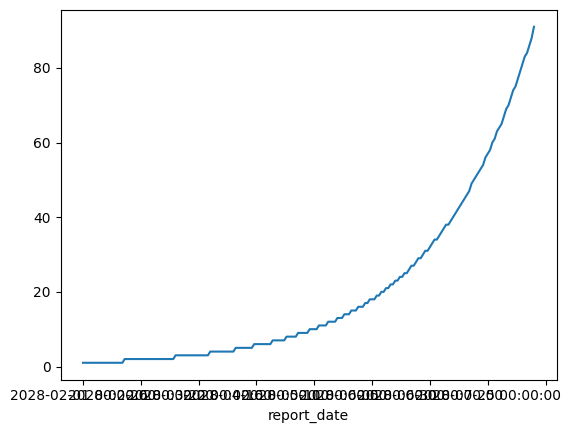

In [19]:
df_zombies.groupby('report_date')['case_id'].count().plot()

## Appendix: A Script to Generate a Random Zombie Outbreak
You don't need to run this! I just included it here to show how I generated the data set we're working with. Feel free to play with it to see what happens! (Right now, this is *not* a realistic pandemic data set).

In [ ]:
import pandas as pd
import numpy as np
from random import choices, randint
from datetime import datetime, timedelta
import math

# List of states to simulate spreading of the outbreak
states = ['MN', 'WI', 'IA', 'SD', 'ND', 'NE', 'IL', 'MI', 'IN', 'OH']

# Define the severity levels and case status
severity_levels = ['Just a Scratch', 'Bitten', 'Mauled']
case_status = ['Recovered', 'Turned', 'Lost to the Horde', 'Unknown']

# Function to generate case_status based on age and severity
def generate_case_status(age, severity):
    if severity == 'Just a Scratch':
        return choices(case_status, weights=[65, 29, 1, 5])[0]
    elif severity == 'Bitten':
        return choices(case_status, weights=[35, 54, 1, 10])[0]
    else: # 'Mauled'
        return choices(case_status, weights=[15, 24, 41, 20])[0]

# Create dataframe
data = {'case_id': [], 'report_date': [], 'location': [], 'symptom_severity': [], 'case_status': [], 'age': []}

start_date = datetime(2028, 2, 1)
end_date = datetime(2028, 8, 31)
num_days = (end_date - start_date).days

# Exponential growth parameters
a = 1  # initial number of cases
r = np.log(2) / 30  # rate, set to double every month

# Generate t values (one for each day), evenly spaced between 0 and the total number of days
t_values = np.linspace(0, num_days, num=num_days+1)

# Calculate the number of cases for each day, round to nearest integer
case_counts = np.rint(a * np.exp(r * t_values)).astype(int)

# Create an array of dates to choose from
dates = np.array([start_date + timedelta(days=int(t)) for t in t_values])

# Calculate the cumulative case counts
cumulative_case_counts = np.cumsum(case_counts)

# Assign a date to each case according to the cumulative case counts
case_dates = np.searchsorted(cumulative_case_counts, np.arange(1, 5001))

for i in range(5000):
    # Get the date
    date = dates[case_dates[i]]

    # generate location based on the date (more recent dates have more states)
    location = np.random.choice(states[:max(1, (date-start_date).days//(num_days//len(states)))])

    # generate age (more older people as per severity)
    age = int(np.random.normal(loc=50, scale=20))
    if age < 0: age = 0
    if np.random.rand() < 0.1:  # 10% chance of age being unknown
        age = -1

    # generate symptom severity (more severe for older people)
    symptom_severity = choices(severity_levels, weights=[70, 20, 10] if age != -1 else [10, 20, 70])[0]

    # generate case_status based on symptom_severity and age
    case_status_generated = generate_case_status(age, symptom_severity)

    # append generated data to the dictionary
    data['case_id'].append(i)
    data['report_date'].append(date.strftime("%Y-%m-%d"))
    data['location'].append(location)
    data['symptom_severity'].append(symptom_severity)
    data['case_status'].append(case_status_generated)
    data['age'].append(age)

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('zombie_outbreak.csv', index=False)
